In [1]:
import sys
import os
from PIL import Image
from itertools import product
from pathlib import Path

import numpy as np
import scipy

import numba

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

from sklearn.metrics import pairwise_distances
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Model

from openTSNE import TSNE
from openTSNE.sklearn import TSNE as sklTSNE
from openTSNE.callbacks import ErrorLogger

import sys
import math

import tensorflow as tf
from tensorflow.keras.layers import Flatten

from itertools import product

from VisionEngine.datasets import guppies
from VisionEngine.utils.config import process_config
from VisionEngine.utils import factory

import tqdm

In [2]:
cd ..

/home/etheredge/Workspace/VisionEngine


In [3]:
checkpoint_path = '/home/etheredge/Workspace/VisionEngine/models/checkpoints/guppy_vae_mmd5000_nokl_wpercep_reconp5/2020-079-17/guppy_vae_mmd5000_nokl_wpercep_reconp5.hdf5'

In [4]:
config_file = 'VisionEngine/configs/guppy_vae_config_mmd5000_nokl_wpercep_reconp5.json'
config = process_config(config_file)

In [5]:
model = factory.create(
            "VisionEngine.models."+config.model.name
            )(config)

importing VisionEngine.models.vae_model
getattr VAEModel
Model: "vlae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 984064), (No 9918848     input_2[0][0]                    
__________________________________________________________________________________________________
normal_variational (NormalVaria (None, 10)           19681301    encoder[1][0]                    
__________________________________________________________________________________________________
normal_variational_1 (NormalVar (None, 10)           4014101     encoder[1][1]                    
______________________________________

In [6]:
model.load(checkpoint_path)

Loading model checkpoint /home/etheredge/Workspace/VisionEngine/models/checkpoints/guppy_vae_mmd5000_nokl_wpercep_reconp5/2020-079-17/guppy_vae_mmd5000_nokl_wpercep_reconp5.hdf5 ...

Model loaded


In [7]:
population = 1000
generations = 1000
n_latents = 4
latent_size = 10

In [8]:
X = np.random.uniform(low=-10,high=10,size=(4, 100000, 10))

In [9]:
def reconstruct_images(x):
    return model.decoder.predict(X)

In [73]:
orange_min = tf.constant([0.9, 0.55, 0.])
orange_max = tf.constant([1., 0.75, 0.1])
black_min = tf.constant([0., 0., 0.])
black_max = tf.constant([[0.2, 0.2, 0.2]])
weights = [1., 1.]

fitness = []
for i in tqdm.tqdm(range(100000)):
    x_hat = model.decoder.predict([np.expand_dims(X[0,i],axis=0),
                                                np.expand_dims(X[1,i],axis=0),
                                                np.expand_dims(X[2,i],axis=0),
                                                np.expand_dims(X[3,i],axis=0)])
    orange_vals = tf.math.logical_and(
            tf.math.greater(x_hat,orange_min),
            tf.math.less(x_hat, orange_max))
    percent_orange = tf.reduce_sum(tf.cast(tf.reduce_all(
                orange_vals,axis=(3)
            ),dtype=tf.float32
        ),axis=(1,2))
    black_vals = tf.math.logical_and(
            tf.math.greater(x_hat,black_min),
            tf.math.less(x_hat, black_max))
    percent_black = tf.reduce_sum(tf.cast(tf.reduce_all(
                black_vals,axis=(3)
            ),dtype=tf.float32
        ),axis=(1,2))
    # fitness is just a simple weighted sum here
    fit = tf.math.reduce_sum([percent_orange*weights[0],percent_black*weights[1]],axis=0)
    fitness.append(fit)

100%|██████████| 100000/100000 [32:26<00:00, 51.39it/s]


In [75]:
fit = np.array(fitness)

In [79]:
np.save('attribute_table_guppies', X)
np.save('fitness_table_guppies', fit)

In [11]:
X = np.load('attribute_table_guppies.npy')
fit = np.load('fitness_table_guppies.npy')

In [78]:
np.mean(fit)

15.03173

In [77]:
np.min(fit)

0.0

In [81]:
population_size = 1000
generations = 1000
n_latents = 4
latent_size = 10

In [82]:
@numba.jit(nopython=True, parallel=True)
def fitness(parents, attribute_table, fitness_table):
    '''
    We define a simple fitness metric where the percent orange
    and percent black contribute to higher fitness.
    We use a lookup table of a predefined fitness landscape (for speed).
    '''
    fitness = []
    for i in range(len(parents)):
        fitness.append(np.argmin(np.sum(np.abs(attribute_table - parents[i]),axis=1)))

    return fitness
        
def selection(parents, fitness, persistence=0.5, temperature=0.2):
    '''
    perform the selection step on the next generation of parents
    '''
    p_dist = np.array(fitness/np.sum(fitness)).flatten()
    indexes = np.arange(len(parents))
    survivors = parents[np.random.choice(indexes, int(population_size*persistence), p=p_dist)]
    survivors = np.concatenate([survivors, parents[np.random.choice(indexes, int(population_size*temperature))]])
    return survivors

def mutate(child, mutation_rate=1, temperature=3):
    '''
    add mutations to offspring
    '''
    # add N random mutations to child with a given temperature
    # destabilizing 
    for _ in range(mutation_rate):
        z_i = np.random.choice(range(n_latents))
        z_i_j = np.random.choice(range(latent_size))
        child[z_i][0][z_i_j] = np.random.normal(loc=0, scale=temperature)
    # stabilizing 
    for _ in range(mutation_rate):
        z_i = np.random.choice(range(n_latents))
        z_i_j = np.random.choice(range(latent_size))
        child[z_i][0][z_i_j] = 0.

    return child

def crossing(parents):
    '''
    pass on alleles
    '''
    offspring = []
    for _ in range(int(population_size - len(parents))):

        # pick a couple of parents
        parent1 = parents[np.random.choice(np.arange(len(parents)))]
        parent2 = parents[np.random.choice(np.arange(len(parents)))]
        
        # randomly initialize child
        child = [
            np.random.multivariate_normal([0] * latent_size,np.diag([1] * latent_size), 1)
            ] * n_latents

        # randomly combine traits from each parent with equal probability
        locs = product(range(n_latents),range(latent_size))
        for z_i, z_i_j in locs:
            child[z_i][0][z_i_j] = np.random.choice([parent1[z_i][z_i_j], parent2[z_i][z_i_j]])
        
        child = mutate(child)
        offspring.append(np.array(child).reshape(4,10))

    return np.array(offspring)

def main():
    # start with an initial population
    parent_record = []
    parents = [
            np.random.multivariate_normal([0] * latent_size,np.diag([1] * latent_size), population_size)
            ] * n_latents
    
    
    # load our fitness surface
    attribute_table = X
    fitness_table = fit
    
    # reshape arrays
    parents = np.transpose(np.array(parents), (1,0,2))
    attribute_table = np.transpose(attribute_table, (1,0,2))
    # start the evolutionary process
    for _ in tqdm.tqdm(range(generations)):
        parent_fitness = fitness(parents.reshape(parents.shape[0],np.prod(parents.shape[1:])),
                                 attribute_table.reshape(attribute_table.shape[0],np.prod(attribute_table.shape[1:])),
                                 fitness_table)
        survivors = selection(parents, parent_fitness)
        offspring = crossing(survivors)  # also includes mutation
        parents = np.concatenate([survivors,offspring])
        parent_record.append(parents)
    return parent_record

In [83]:
parent_record = main()

100%|██████████| 1000/1000 [6:51:10<00:00, 24.67s/it] 


In [84]:
pr = np.transpose(np.array(parent_record), (0,2,1,3))

In [85]:
np.save('pr_guppies_orig_params_new_fit', pr)

In [86]:
import numpy as np

In [87]:
pwd

'/home/etheredge/Workspace/VisionEngine'

In [8]:
pr = np.load('pr_guppies_orig_params_new_fit.npy')

In [9]:
orig_sample = [pr[0][0][:], pr[0][1][:], pr[0][2][:], pr[0][3][:]]
evol_sample = [pr[-1][0][:], pr[-1][1][:], pr[-1][2][:], pr[-1][3][:]]



In [12]:

@numba.jit(nopython=True, parallel=True)
def fitness(parents, attribute_table, fitness_table):
    '''
    We define a simple fitness metric where the percent orange
    and percent black contribute to higher fitness.
    We use a lookup table of a predefined fitness landscape (for speed).
    '''
    fitness = []
    for i in range(len(parents)):
        fitness.append(np.argmin(np.sum(np.abs(attribute_table - parents[i]),axis=1)))

    return fitness
attribute_table = X
fitness_table = fit

# reshape arrays
parents = np.transpose(np.array(evol_sample), (1,0,2))
attribute_table = np.transpose(attribute_table, (1,0,2))


evol_fitness = fitness(parents.reshape(parents.shape[0],np.prod(parents.shape[1:])),
                         attribute_table.reshape(attribute_table.shape[0],np.prod(attribute_table.shape[1:])),
                         fitness_table)

In [13]:

@numba.jit(nopython=True, parallel=True)
def fitness(parents, attribute_table, fitness_table):
    '''
    We define a simple fitness metric where the percent orange
    and percent black contribute to higher fitness.
    We use a lookup table of a predefined fitness landscape (for speed).
    '''
    fitness = []
    for i in range(len(parents)):
        fitness.append(np.argmin(np.sum(np.abs(attribute_table - parents[i]),axis=1)))

    return fitness
attribute_table = X
fitness_table = fit

# reshape arrays
parents = np.transpose(np.array(orig_sample), (1,0,2))
attribute_table = np.transpose(attribute_table, (1,0,2))


orig_fitness = fitness(parents.reshape(parents.shape[0],np.prod(parents.shape[1:])),
                         attribute_table.reshape(attribute_table.shape[0],np.prod(attribute_table.shape[1:])),
                         fitness_table)

In [24]:
orig_sample = [
    pr[0][0][np.argsort(orig_fitness)[1:2]],
    pr[0][1][np.argsort(orig_fitness)[1:2]],
    pr[0][2][np.argsort(orig_fitness)[1:2]],
    pr[0][3][np.argsort(orig_fitness)[1:2]]
]

evol_sample = [
    pr[-1][0][np.argsort(evol_fitness)[::-1][1:2]],
    pr[-1][1][np.argsort(evol_fitness)[::-1][1:2]],
    pr[-1][2][np.argsort(evol_fitness)[::-1][1:2]],
    pr[-1][3][np.argsort(evol_fitness)[::-1][1:2]]
]

In [25]:
evol_generated = model.model.get_layer('decoder').predict(evol_sample, batch_size=1)
evol_generated = evol_generated.reshape(1, 256, 256,3)
orig_generated = model.model.get_layer('decoder').predict(orig_sample, batch_size=1)
orig_generated = orig_generated.reshape(1, 256, 256,3)

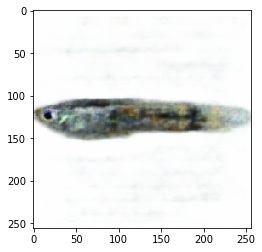

In [26]:
plt.imshow(orig_generated[0])

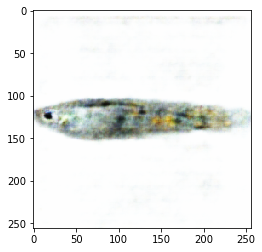

In [27]:
plt.imshow(evol_generated[0])

In [34]:
orig_sample[0].shape

(1, 10)

In [52]:
interpos = [np.linspace(orig_sample[i][0], evol_sample[i][0], num=250).astype('float32') for i in range(4)]

In [53]:
def reconstruct_images(x):
    return model.model.get_layer('decoder').predict(x)


In [54]:
interpos[0].dtype

dtype('float32')

In [55]:
imgs = reconstruct_images(interpos)

In [66]:
interpo[0]

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0,

In [67]:
image_output_folder = 'report_final/figures/images/VR_images{}'.format(checkpoint_path.split('/')[7])
Path(image_output_folder).mkdir(parents=True, exist_ok=True)
for i, interpo in enumerate(imgs):
    interpo = interpo * 255
    interpo = interpo.astype(np.uint8)
    img = Image.fromarray(interpo)
    img.save(os.path.join(image_output_folder,'sample_{:04d}.jpg'.format(i)))

In [ ]:
def make_traversal_from_sample(model, z, n_samples=1, num_steps=11, sample_id=0):
    output_folder = os.path.join(image_output_folder, 'explore_latents/traversal')
    Path(output_folder).mkdir(parents=True, exist_ok=True)
    multipliers = np.linspace(-3,3,num=num_steps)
    encoded_sample = [z_i[sample_id] for z_i in z]

    for z_i in range(4):
        image_container = Image.new('RGB', (256*num_steps,256*latent_size))
        for z_i_j in range(latent_size):
            for s in range(num_steps):
                sample = [np.array([encoded_sample[0]]),
                      np.array([encoded_sample[1]]),
                      np.array([encoded_sample[2]]),
                      np.array([encoded_sample[3]])]
                
                sample[z_i][0][z_i_j] = multipliers[s]
                generated = model.get_layer('decoder').predict(sample, batch_size=1)
                generated = generated.reshape((256, 256, 3))
                img = 255 * np.array(generated)
                img = img.astype(np.uint8)
                image_container.paste(Image.fromarray(img.astype('uint8')), (s*256, z_i_j*256))
        image_container.save(os.path.join(output_folder,'{}sample{}.png'.format(sample_id, z_i)))



In [89]:
Z = np.concatenate([z_ for z_ in pr], axis=1)
Z = Z.reshape(1000000, 40)
Z.shape

(1000000, 40)

In [90]:
embedding = TSNE(callbacks=ErrorLogger(), n_jobs=-1, learning_rate=len(Z)/12, exaggeration=4).fit(Z)

Iteration   50, KL divergence  9.4347, 50 iterations in 26.1310 sec
Iteration  100, KL divergence  9.4181, 50 iterations in 27.4590 sec
Iteration  150, KL divergence  9.4587, 50 iterations in 27.0458 sec
Iteration  200, KL divergence  9.4268, 50 iterations in 28.3996 sec
Iteration  250, KL divergence  9.4457, 50 iterations in 27.5119 sec
Iteration   50, KL divergence  7.9737, 50 iterations in 28.3093 sec
Iteration  100, KL divergence  7.7113, 50 iterations in 29.1375 sec
Iteration  150, KL divergence  7.6448, 50 iterations in 28.8432 sec
Iteration  200, KL divergence  7.6141, 50 iterations in 29.5546 sec
Iteration  250, KL divergence  7.5955, 50 iterations in 27.4428 sec
Iteration  300, KL divergence  7.5802, 50 iterations in 27.0522 sec
Iteration  350, KL divergence  7.5684, 50 iterations in 26.7945 sec
Iteration  400, KL divergence  7.5598, 50 iterations in 26.8468 sec
Iteration  450, KL divergence  7.5534, 50 iterations in 26.6682 sec
Iteration  500, KL divergence  7.5459, 50 iterat

In [91]:
np.save('embedding_guppies', embedding)

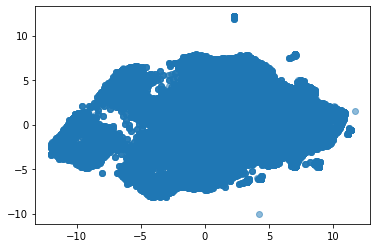

In [92]:
plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.5)

In [232]:
h_0 = np.load('../data/processed/h_0_gan.npy')
h_1 = np.load('../data/processed/h_1_gan.npy')
h_2 = np.load('../data/processed/h_2_gan.npy')
h_3 = np.load('../data/processed/h_3_gan.npy')

In [233]:
h_0[0]

array([ 0.7203403 ,  1.1620867 , -1.3740046 , -1.7832572 , -1.6159137 ,
        2.5350747 ,  0.46580508, -1.2940897 , -0.63609946,  0.43665546],
      dtype=float32)

In [231]:
Z[1]

array([-2.20341033, -3.95076818, -0.65522831,  1.3291521 ,  2.97812752,
        2.41437032, -1.70049543,  0.62732628, -3.92466744,  1.77238787,
        2.76624155,  1.69985833, -1.09877967, -1.96517926,  2.20316475,
        3.04870411,  1.88064851, -0.29284526, -1.4040443 , -0.72757693,
        0.29773065,  3.89931583,  1.81328634,  0.02922803,  3.06141118,
        0.11708313,  0.2275759 ,  3.94375056, -0.98492768,  0.38183345,
        1.87069024,  1.77226624,  1.14304597,  1.1030602 ,  2.31192925,
       -1.53453292,  0.32111182, -3.01464578,  1.92918368, -0.19434594])

In [235]:
model_folder = '../checkpoints/vlae_mmd_all'
def custom_loss(x,xhat):
        return  .5 * tf.losses.mean_squared_error(tf.keras.layers.Flatten()(x), tf.keras.layers.Flatten()(xhat)) * np.prod([256,256,3])
vae = tf.keras.models.load_model(model_folder, custom_objects={'loss': custom_loss}, compile=False)
vae.compile()

In [22]:
pr[0][1][:100].shape

(100, 10)

In [35]:
len(pr)

1000

In [160]:
orig_sample = [pr[0][0][:], pr[0][1][:], pr[0][2][:], pr[0][3][:]]
evol_sample = [pr[-1][0][:], pr[-1][1][:], pr[-1][2][:], pr[-1][3][:]]

In [165]:
evol_fitness

[98301,
 91673,
 86131,
 86131,
 86062,
 90662,
 82599,
 98301,
 98301,
 86131,
 81801,
 86131,
 81801,
 98301,
 98301,
 98301,
 81801,
 86896,
 90662,
 86131,
 86131,
 98301,
 86131,
 98301,
 86131,
 82735,
 98301,
 98301,
 64067,
 43740,
 98301,
 98301,
 86131,
 33726,
 42727,
 98301,
 59721,
 95317,
 98301,
 98301,
 54236,
 91673,
 81801,
 98301,
 86131,
 86131,
 90662,
 82735,
 91673,
 86131,
 98301,
 86131,
 98301,
 86131,
 91673,
 86131,
 78237,
 98301,
 86131,
 86131,
 98301,
 98301,
 76332,
 98301,
 90662,
 80265,
 82599,
 81801,
 59721,
 86131,
 41702,
 86131,
 98301,
 98301,
 86131,
 95796,
 86131,
 98301,
 98301,
 86131,
 90662,
 64067,
 98301,
 44391,
 98301,
 86131,
 98301,
 86131,
 91673,
 86131,
 86131,
 59721,
 98301,
 98301,
 81801,
 98301,
 86131,
 90662,
 86131,
 86131,
 33726,
 76332,
 98301,
 98301,
 98301,
 98301,
 98301,
 98301,
 98301,
 86131,
 98301,
 81801,
 98301,
 98301,
 86131,
 66620,
 86131,
 59721,
 86131,
 98301,
 81801,
 86131,
 98301,
 98301,
 86131,


In [166]:
np.argsort(evol_fitness)[::-1][:100]

array([986, 831,   0, 429, 424, 805, 423, 419, 415, 411, 410, 811, 408,
       407, 404, 401, 400, 426, 432, 819, 458, 476, 464, 788, 460, 459,
       791, 457, 434, 794, 454, 452, 797, 447, 443, 396, 820, 480, 337,
       311, 316, 319, 853, 852, 320, 321, 325, 330, 332, 334, 844, 335,
       336, 340, 821, 347, 838, 349, 836, 835, 352, 357, 364, 368, 372,
       379, 382, 389, 390, 477, 484, 309, 620, 646, 635, 630, 629, 737,
       621, 616, 486, 615, 611, 610, 606, 745, 746, 647, 651, 654, 659,
       660, 664, 665, 666, 671, 672, 681, 684, 687])

In [252]:
orig_sample = [
    pr[0][0][np.argsort(orig_fitness)[::-1][:25]],
    pr[0][1][np.argsort(orig_fitness)[::-1][:25]],
    pr[0][2][np.argsort(orig_fitness)[::-1][:25]],
    pr[0][3][np.argsort(orig_fitness)[::-1][:25]]
]

evol_sample = [
    pr[-1][0][np.argsort(evol_fitness)[::-1][:25]],
    pr[-1][1][np.argsort(evol_fitness)[::-1][:25]],
    pr[-1][2][np.argsort(evol_fitness)[::-1][:25]],
    pr[-1][3][np.argsort(evol_fitness)[::-1][:25]]
]

In [253]:
orig_generated = model.model.get_layer('decoder').predict(orig_sample, batch_size=1)
orig_generated = orig_generated.reshape((25, 256, 256,3))

In [254]:
evol_generated = model.model.get_layer('decoder').predict(evol_sample, batch_size=1)
evol_generated = evol_generated.reshape((25, 256, 256,3))

In [255]:
from PIL import Image

In [263]:
image_container = Image.new('RGBA', (256*5,256*5))
locs = list(product(range(5),range(5)))
for i, file in enumerate(evol_generated):
    j, k = locs[i]
    img = 255 * np.array(file)
    img = img.astype(np.uint8)
    image_container.paste(Image.fromarray(img.astype('uint8')), (j*256, k*256))

In [264]:
image_container_orig = Image.new('RGBA', (256*5,256*5))
locs = list(product(range(5),range(5)))
for i, file in enumerate(orig_generated):
    j, k = locs[i]
    img = 255 * np.array(file)
    img = img.astype(np.uint8)
    image_container_orig.paste(Image.fromarray(img.astype('uint8')), (j*256, k*256))

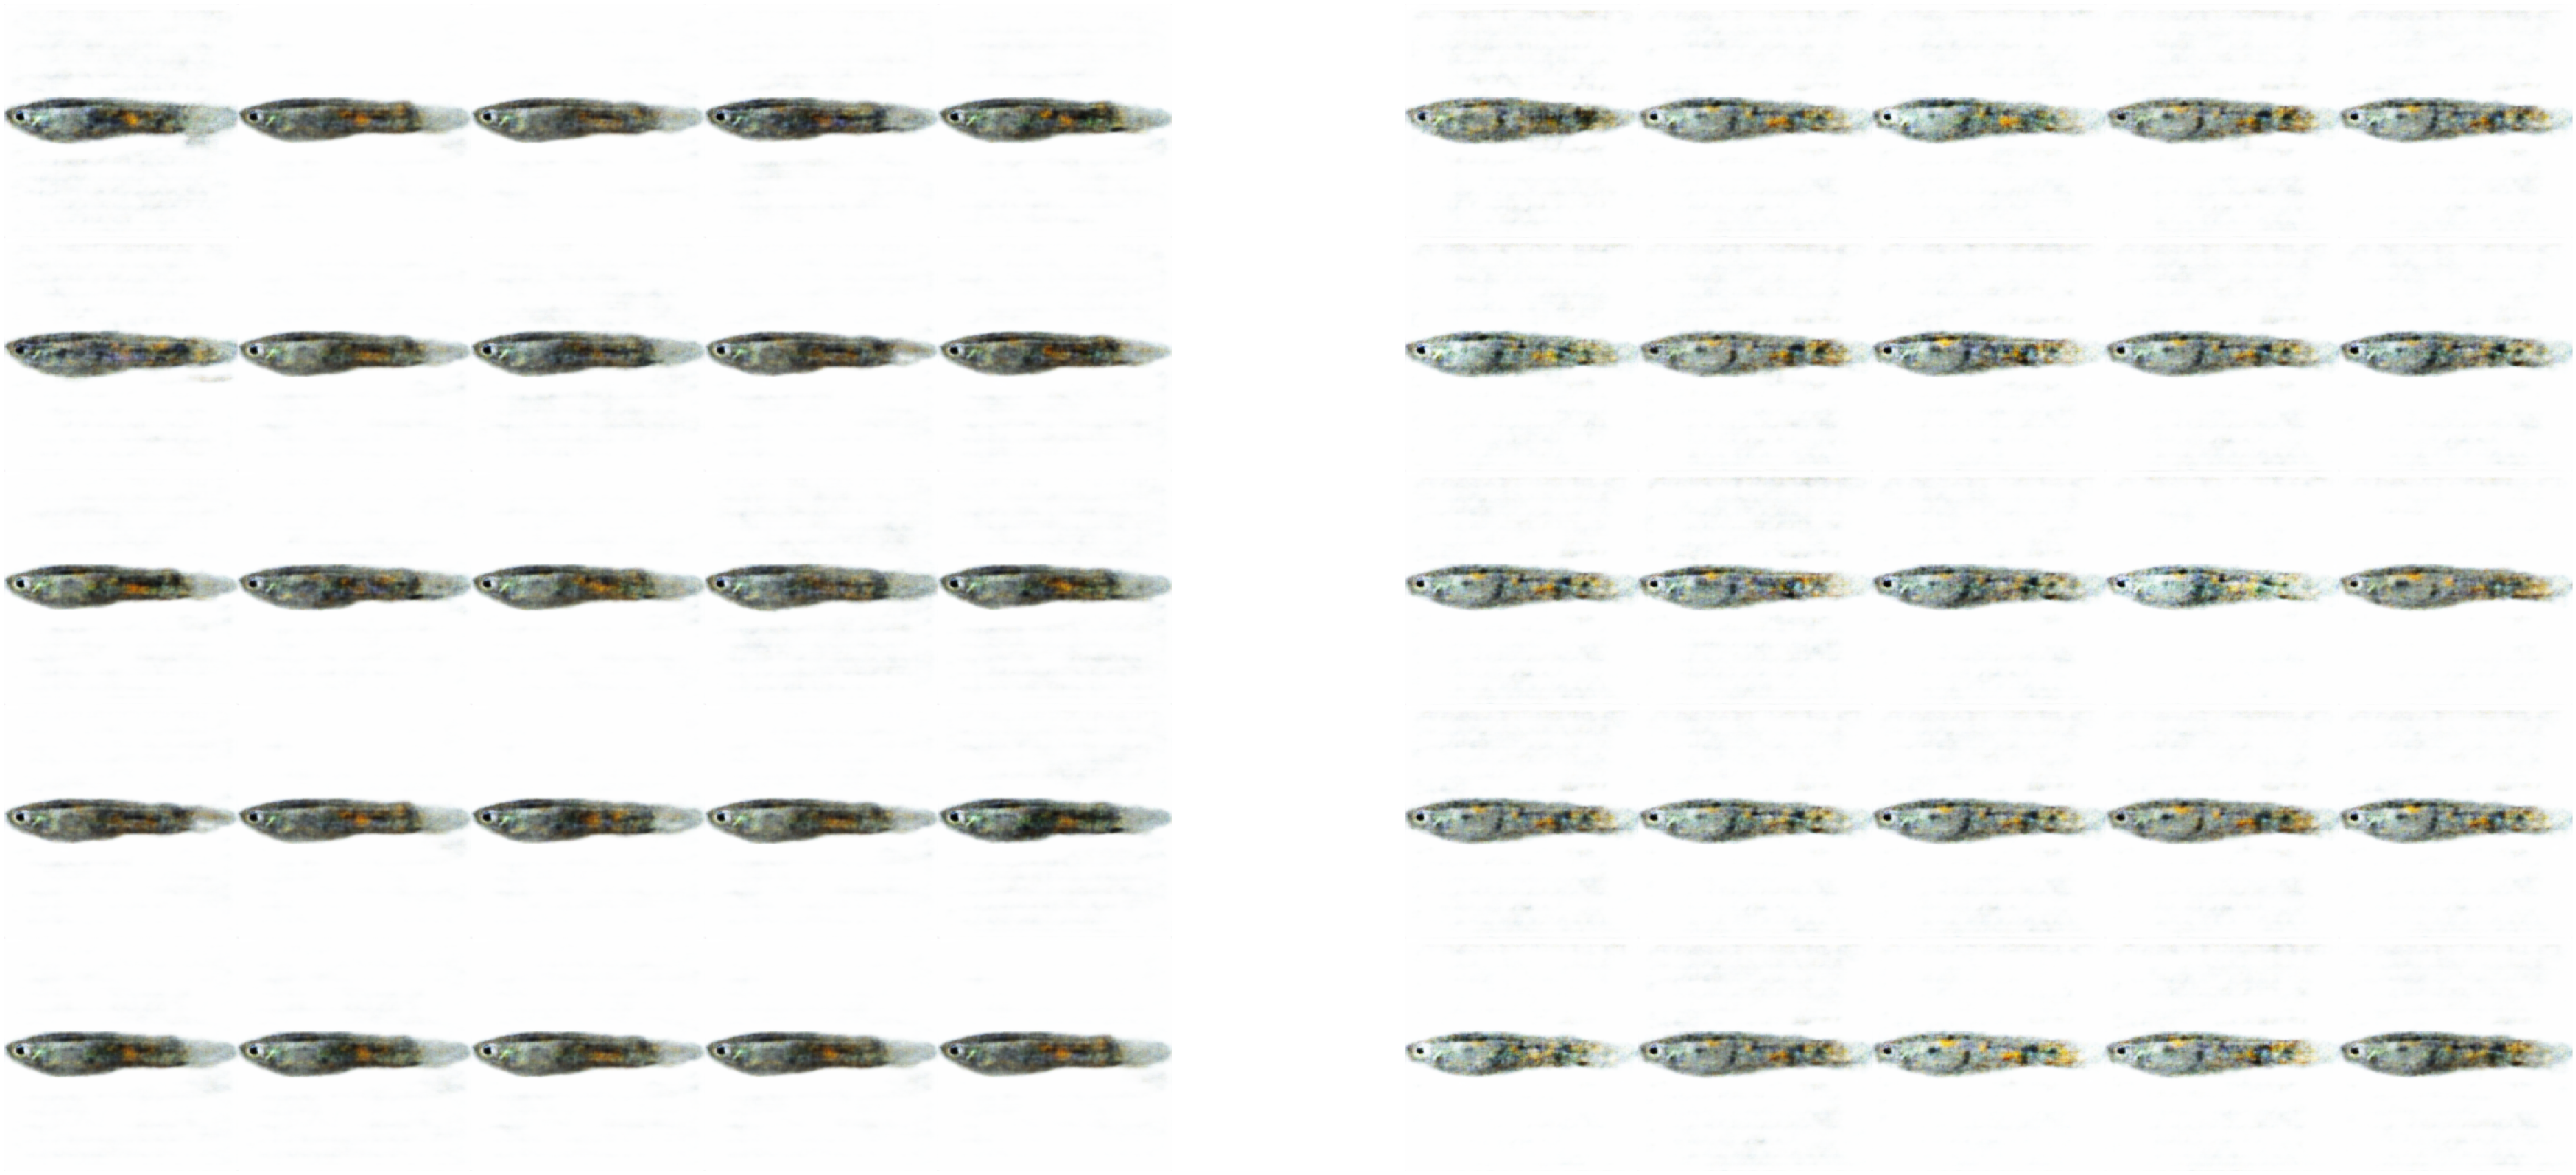

In [266]:
plt.figure(figsize=(80,40))
plt.subplot(121)
plt.imshow(image_container_orig)
plt.axis('off')
plt.subplot(122)
plt.imshow(image_container)
plt.axis('off')
fig = plt.gcf()
fig.savefig('evolved_guppies5.png')

In [217]:
import matplotlib

cmap = matplotlib.cm.get_cmap('viridis')

rgba = cmap(0.5)


In [218]:
vals = np.logspace(0.,1.,11, base=0.1)[::-1]

In [219]:
vals

array([0.1       , 0.12589254, 0.15848932, 0.19952623, 0.25118864,
       0.31622777, 0.39810717, 0.50118723, 0.63095734, 0.79432823,
       1.        ])

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

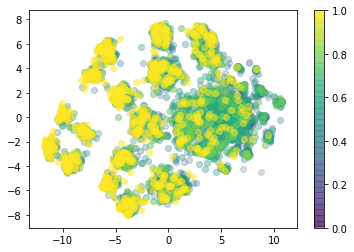

In [223]:
plt.scatter(embedding[:1000, 0], embedding[:1000, 1], alpha=vals[0]/2, c=cmap(vals[0]))
plt.scatter(embedding[100000:101000, 0], embedding[100000:101000, 1], alpha=vals[1]/2, c=cmap(vals[1]))
plt.scatter(embedding[200000:201000, 0], embedding[200000:201000, 1], alpha=vals[2]/2, c=cmap(vals[2]))
plt.scatter(embedding[300000:301000, 0], embedding[300000:301000, 1], alpha=vals[3]/2, c=cmap(vals[3]))
plt.scatter(embedding[400000:401000, 0], embedding[400000:401000, 1], alpha=vals[4]/2, c=cmap(vals[4]))
plt.scatter(embedding[500000:501000, 0], embedding[500000:501000, 1], alpha=vals[5]/2, c=cmap(vals[5]))
plt.scatter(embedding[600000:601000, 0], embedding[600000:601000, 1], alpha=vals[6]/2, c=cmap(vals[6]))
plt.scatter(embedding[700000:701000, 0], embedding[700000:701000, 1], alpha=vals[7]/2, c=cmap(vals[7]))
plt.scatter(embedding[800000:801000, 0], embedding[800000:801000, 1], alpha=vals[8]/2, c=cmap(vals[8]))
plt.scatter(embedding[900000:901000, 0], embedding[900000:901000, 1], alpha=vals[9]/2, c=cmap(vals[9]))
plt.scatter(embedding[-1000:, 0], embedding[-1000:, 1], alpha=vals[10]/2, c=cmap(vals[10]))
plt.colorbar()

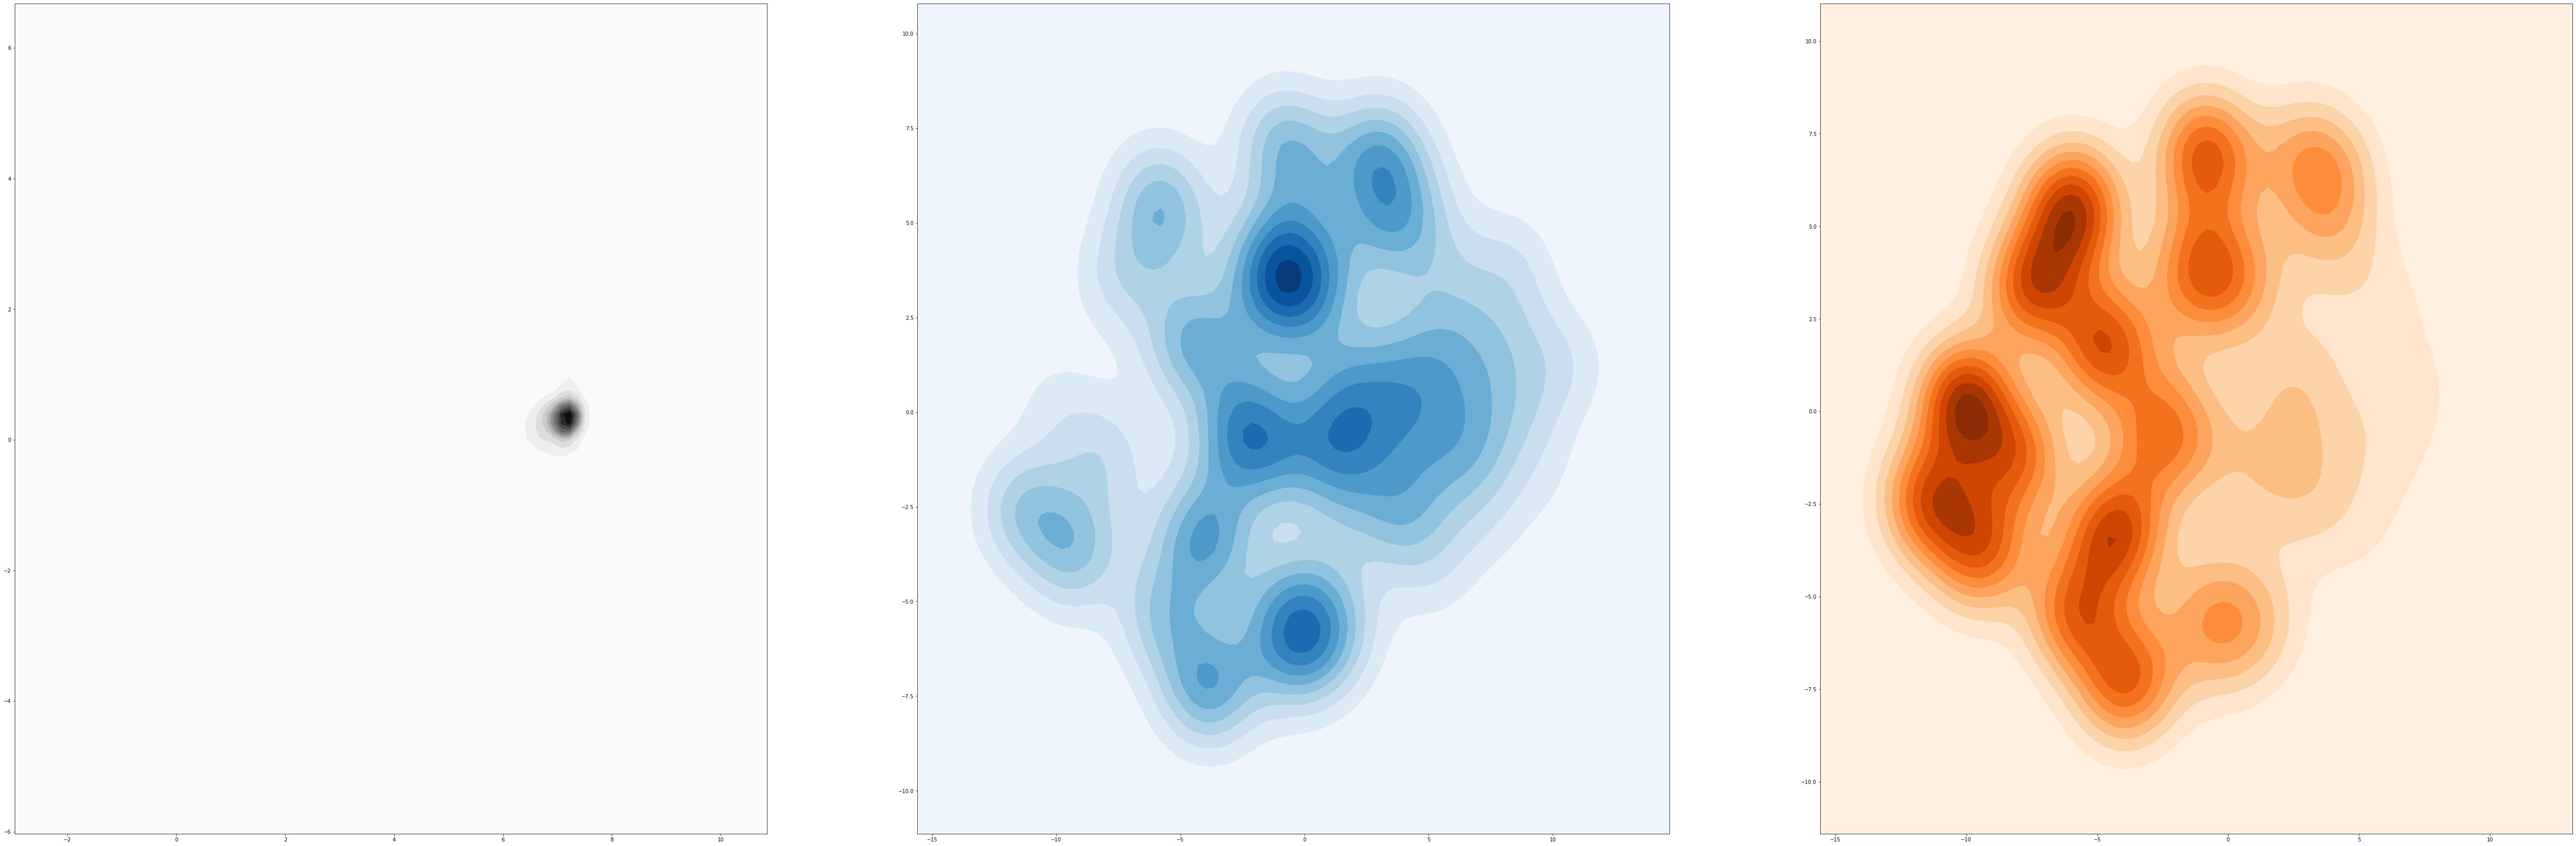

In [247]:
import seaborn as sns
plt.figure(figsize=(90,30))
plt.subplot(131)
sns.kdeplot(embedding[:1000, 0], embedding[:1000, 1], cmap='Greys', shade=True, shade_lowest=False)
plt.subplot(132)
sns.kdeplot(embedding[600000:601000, 0], embedding[600000:601000, 1], cmap='Blues', shade=True, shade_lowest=False)
plt.subplot(133)
sns.kdeplot(embedding[-1000:, 0], embedding[-1000:, 1], cmap='Oranges', shade=True, shade_lowest=False)
fig = plt.gcf()
fig.savefig('evolution_topo.pdf')

In [116]:
evol_fitness = []
for x_hat in tqdm.tqdm(evol_samples):
    orange_vals = tf.math.logical_and(
            tf.math.greater(x_hat,orange_min),
            tf.math.less(x_hat, orange_max))
    percent_orange = tf.math.divide(
        tf.reduce_sum(tf.cast(tf.reduce_all(
                orange_vals,axis=(3)
            ),dtype=tf.float32
        ),axis=(1,2)),
        np.product([256,256]))
    black_vals = tf.math.logical_and(
            tf.math.greater(x_hat,black_min),
            tf.math.less(x_hat, black_max))
    percent_black = tf.math.divide(
        tf.reduce_sum(tf.cast(tf.reduce_all(
                black_vals,axis=(3)
            ),dtype=tf.float32
        ),axis=(1,2)),
        np.product([256,256]))
    # fitness is just a simple weighted sum here
    fit = tf.math.reduce_sum([percent_orange*weights[0],percent_black*weights[1]],axis=0)
    evol_fitness.append(fit)

NameError: name 'evol_samples' is not defined

In [ ]:
plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.5)

In [228]:
import matplotlib.pyplot as plt

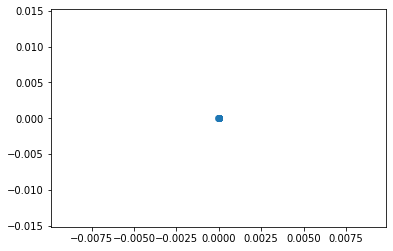

In [229]:
plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.5)

In [201]:
parents = [
            np.random.multivariate_normal([0] * latent_size,np.diag([1] * latent_size), population_size)
            ] * n_latents
    
    
# load our fitness surface
attribute_table = X
fitness_table = fit

# reshape arrays
parents = np.transpose(np.array(parents), (1,0,2))
attribute_table = np.transpose(attribute_table, (1,0,2))
# start the evolutionary process
for _ in tqdm.tqdm(range(generations)):
    parent_fitness = fitness(parents.reshape(parents.shape[0],np.prod(parents.shape[1:])),
                             attribute_table.reshape(attribute_table.shape[0],np.prod(attribute_table.shape[1:])),
                             fitness_table)
    survivors = selection(parents, parent_fitness)
    offspring = crossing(survivors)  # also includes mutation
    parents = np.concatenate([survivors, offspring])








  0%|          | 0/1000 [00:00<?, ?it/s]






  0%|          | 1/1000 [00:23<6:26:27, 23.21s/it]






  0%|          | 2/1000 [00:44<6:16:46, 22.65s/it]






  0%|          | 3/1000 [01:07<6:17:58, 22.75s/it]

KeyboardInterrupt: 

In [15]:

population_size = 1000
generations = 1000
n_latents = 4
latent_size = 10

In [54]:
parents = [
            np.random.multivariate_normal([0] * latent_size,np.diag([1] * latent_size), population_size)
            ] * n_latents

In [55]:
attribute_table = X
fitness_table = fit

In [56]:
parents = np.transpose(np.array(parents), (1,0,2))
attribute_table = np.transpose(attribute_table, (1,0,2))

In [57]:
parents.shape

(1000, 4, 10)

In [58]:
parents[0].shape

(4, 10)

In [71]:
np.abs(attribute_table - parents[0]).shape

(100000, 4, 10)

In [79]:
(np.sum(np.abs(attribute_table - parents[0]),axis=(1,2))).argmin()

47642

In [82]:
def fitness(parents, attribute_table, fitness_table):
    '''
    We define a simple fitness metric where the percent orange
    and percent black contribute to higher fitness.
    We use a lookup table of a predefined fitness landscape (for speed).
    '''
    fitness = np.zeros(len(parents))
    
    for i, parent in enumerate(parents):
        idx = (np.sum(np.abs(attribute_table - parent),axis=(1,2))).argmin()
        fitness[i] = fitness_table[idx]

    return fitness

In [102]:
def selection(parents, fitness, persistence=0.5, temperature=0.2):
    '''
    perform the selection step on the next generation of parents
    '''
    p_dist = fitness/np.sum(fitness)
    indexes = np.arange(len(parents))
    survivors = parents[np.random.choice(indexes, int(population_size*persistence), p=p_dist)]
    survivors = np.concatenate([survivors, parents[np.random.choice(indexes, int(population_size*temperature))]])
    return survivors

In [124]:
def crossing(parents):
    '''
    pass on alleles
    '''
    offspring = []
    for _ in range(int(population_size - len(parents))):

        # pick a couple of parents
        parent1 = parents[np.random.choice(np.arange(len(parents)))]
        parent2 = parents[np.random.choice(np.arange(len(parents)))]
        
        # randomly initialize child
        child = [
            np.random.multivariate_normal([0] * latent_size,np.diag([1] * latent_size), 1)
            ] * n_latents

        # randomly combine traits from each parent with equal probability
        locs = product(range(n_latents),range(latent_size))
        for z_i, z_i_j in locs:
            child[z_i][0][z_i_j] = np.random.choice([parent1[z_i][z_i_j], parent1[z_i][z_i_j]])
        
        child = mutate(child)
        offspring.append(np.array(child).reshape(4,10))

    return np.array(offspring)

In [125]:
# parent_fitness = fitness(parents, attribute_table, fitness_table)
# survivors = selection(parents, parent_fitness)
offspring = crossing(survivors)

In [126]:
np.array(offspring).shape

(300, 4, 10)

In [104]:
survivors.shape

(700, 4, 10)

In [ ]:
survivors.shape

In [85]:
parent_fitness.shape

(1000,)

In [28]:
attribute_table.shape

(4, 100000, 10)

In [27]:
np.transpose(parents, (1, 0, 2)).shape

(1000, 4, 10)

In [163]:
fitness = []
space = []
for _ in range(100):
    random_sampling = [
                np.random.multivariate_normal([0] * latent_size,np.diag([4] * latent_size), 100)
                ] * n_latents
    with tf.device("GPU:0"):
        orange_min = tf.constant([0.9, 0.55, 0.])
        orange_max = tf.constant([1., 0.75, 0.1])
        black_min = tf.constant([0., 0., 0.])
        black_max = tf.constant([[0.2, 0.2, 0.2]])
        weights = [1., 1.]

        x_hat = model.get_layer('decoder').predict(random_sampling)
        orange_vals = tf.math.logical_and(
                tf.math.greater(x_hat,orange_min),
                tf.math.less(x_hat, orange_max))
        percent_orange = tf.math.divide(
            tf.reduce_sum(tf.cast(tf.reduce_all(
                    orange_vals,axis=(3)
                ),dtype=tf.float32
            ),axis=(1,2)),
            np.product([256,256]))
        black_vals = tf.math.logical_and(
                tf.math.greater(x_hat,black_min),
                tf.math.less(x_hat, black_max))
        percent_black = tf.math.divide(
            tf.reduce_sum(tf.cast(tf.reduce_all(
                    black_vals,axis=(3)
                ),dtype=tf.float32
            ),axis=(1,2)),
            np.product([256,256]))
        # fitness is just a simple weighted sum here
        fit = tf.math.reduce_sum([percent_orange*weights[0],percent_black*weights[1]],axis=0)
    space.append(np.array(random_sampling))
    fitness.append(fit)

In [166]:
fitness[0]

<tf.Tensor: id=44429, shape=(100,), dtype=float32, numpy=
array([0.01226807, 0.01716614, 0.02246094, 0.0112915 , 0.01858521,
       0.01182556, 0.0196991 , 0.0213623 , 0.02508545, 0.01152039,
       0.02233887, 0.02745056, 0.01451111, 0.01927185, 0.01239014,
       0.01872253, 0.02212524, 0.03056335, 0.0219574 , 0.04077148,
       0.02485657, 0.02165222, 0.03707886, 0.02677917, 0.02763367,
       0.0171814 , 0.01983643, 0.02645874, 0.0459137 , 0.02339172,
       0.01579285, 0.02206421, 0.02986145, 0.00428772, 0.03051758,
       0.0222168 , 0.02642822, 0.03146362, 0.01687622, 0.01934814,
       0.01571655, 0.02914429, 0.01248169, 0.01495361, 0.02377319,
       0.02763367, 0.03549194, 0.03387451, 0.01985168, 0.02806091,
       0.01025391, 0.02044678, 0.02424622, 0.03086853, 0.02412415,
       0.03334045, 0.01608276, 0.03001404, 0.03968811, 0.01586914,
       0.02154541, 0.03688049, 0.02923584, 0.01937866, 0.02227783,
       0.03286743, 0.03192139, 0.03919983, 0.01968384, 0.03735352,
    

In [142]:
np.array(uniform).shape

(4, 10, 1000)

In [17]:
child = [
            np.random.multivariate_normal([0] * latent_size,np.diag([1] * latent_size), 1)
            ] * n_latents

In [19]:
child[0].shape

(1, 10)

In [13]:
child

[array([[ 0.98105804,  0.58213917,  0.97734226, -1.65639373,  1.76520232,
          0.56862362, -0.03511802,  2.50743429,  0.56445633, -0.59183489]]),
 array([[ 0.98105804,  0.58213917,  0.97734226, -1.65639373,  1.76520232,
          0.56862362, -0.03511802,  2.50743429,  0.56445633, -0.59183489]]),
 array([[ 0.98105804,  0.58213917,  0.97734226, -1.65639373,  1.76520232,
          0.56862362, -0.03511802,  2.50743429,  0.56445633, -0.59183489]]),
 array([[ 0.98105804,  0.58213917,  0.97734226, -1.65639373,  1.76520232,
          0.56862362, -0.03511802,  2.50743429,  0.56445633, -0.59183489]])]

In [15]:
locs = product(range(n_latents),range(latent_size))
for z_i, z_i_j in locs:
    child[z_i][0][z_i_j] = np.random.choice([parent1[z_i][0][z_i_j],parent1[z_i][0][z_i_j]])

In [16]:
child

[array([[ 0.50090697, -0.44479713, -0.47266571, -0.10057938,  0.69694359,
          0.29683328,  0.13111999,  0.08067502, -0.09645291, -0.06237675]]),
 array([[ 0.50090697, -0.44479713, -0.47266571, -0.10057938,  0.69694359,
          0.29683328,  0.13111999,  0.08067502, -0.09645291, -0.06237675]]),
 array([[ 0.50090697, -0.44479713, -0.47266571, -0.10057938,  0.69694359,
          0.29683328,  0.13111999,  0.08067502, -0.09645291, -0.06237675]]),
 array([[ 0.50090697, -0.44479713, -0.47266571, -0.10057938,  0.69694359,
          0.29683328,  0.13111999,  0.08067502, -0.09645291, -0.06237675]])]